In [11]:

import os
import numpy as np
import pandas as pd
import wandb
from datetime import datetime
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

api = wandb.Api()

In [2]:
def make_table_from_metric(
    metric,
    results,
    val_metric=None,
    ci=0.95,
    latex=False,
    bold=True,
    drop_nans=False,
    show_group=False,
    select_best=True,
    pm=True
):
    if val_metric is None:
        val_metric = metric

    alpha = (1 - ci) / 2

    if drop_nans:
        results = results[results[metric].notna()]
        results = results[results[val_metric].notna()]

    def half_ci(group):
        data = group.to_numpy()
        sem = stats.sem(data)
        t2 = stats.t.ppf(1 - alpha, len(data) - 1) - stats.t.ppf(alpha, len(data) - 1)
        return sem * (t2 / 2)
        # return np.std(data)

    def lower_ci(group):
        data = group.to_numpy()
        sem = stats.sem(data)
        mean = data.mean()
        t = stats.t.ppf(alpha, len(data) - 1)
        return mean + sem * t

    def upper_ci(group):
        data = group.to_numpy()
        sem = stats.sem(data)
        mean = data.mean()
        t = stats.t.ppf(1 - alpha, len(data) - 1)
        return mean + sem * t

    def count(group):
        data = group.to_numpy()
        return np.prod(data.shape)
    

    results = (
        results.groupby(by=["group", "method", "dataset"])
        .agg(
            {
                metric: ["mean", "std", "sem", lower_ci, upper_ci, half_ci, count],
                val_metric: [
                    "mean",
                    "std",
                    "sem",
                    lower_ci,
                    upper_ci,
                    half_ci,
                    count,
                ],
            }
        )
        .reset_index()
    )

    if select_best:
        group_max_idx = (
            results.groupby(by=["method", "dataset"]).transform(max)[val_metric]["mean"]
            == results[val_metric]["mean"]
        )
        table = results[group_max_idx]
    else:
        table = results

    # table = table[table["dataset"].isin(["Earthquake", "Fire", "Flood", "Volcano"])]

    if latex:

        def format_result(row):
            if pm:
                return (
                    f"{{{row[metric]['mean']:0.2f}_{{\pm {row[metric]['half_ci']:0.2f}}}}}"
                )
            else:
                return f"{{{row[metric]['mean']:0.2f}}}"


        def bold_result(row):
            return "\\bm" + row["result"] if row["bold"].any() else row["result"]

    else:

        def format_result(row):
            if pm:
                return f"{row[metric]['mean']:0.2f} ± {row[metric]['half_ci']:0.2f}"
            else:
                return f"{row[metric]['mean']:0.2f}"

        def bold_result(row):
            return "* " + row["result"] if row["bold"].any() else row["result"]

    table["group_max"] = table.groupby(by=["dataset"]).transform(max)[metric]["mean"]
    table["group_max"] = table.apply(
        lambda row: table.index[table[metric]["mean"] == row["group_max"].squeeze()][0],
        axis=1,
    )
    table["bold"] = table.apply(
        lambda row: (
            table.loc[row["group_max"], (metric, "mean")].squeeze()
            < row[metric]["upper_ci"]
        )
        or (
            row[metric]["mean"]
            > table.loc[row["group_max"], (metric, "lower_ci")].squeeze()
        ),
        axis=1,
    )

    table["result"] = table.apply(format_result, axis=1)
    if bold:
        table["result"] = table.apply(bold_result, axis=1)

    if latex:
        table["result"] = table.apply(lambda row: "$" + row["result"] + "$", axis=1)

    table["count"] = table[(metric, "count")]

    return table
    cols = (
        ["method", "dataset", "group"] if show_group else ["method", "dataset", "count"]
    )
    table_flat = table[cols].pivot(index="method", columns="dataset")

    return table_flat


In [51]:
runs = api.runs(
    "emilem/equiv-stochastic-diffusion-processes",
    filters={
        "createdAt": {"$gte": "2023-04-20T00:00:00.000Z"}
        # 'config.name': 'fire's
    },
)

summary_list, config_list, name_list = [], [], []

rows = []

for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # config = {"config/" + k: v for k, v in run.config.items() if not k.startswith("_")}
    config = {k: v for k, v in run.config.items() if not k.startswith("_")}

    # .name is the human-readable name of the run.
    name_list.append(run.name)

    rows.append(
        {
            "group": run.group,
            **run.summary._json_dict,
            **config,
        }
    )

runs_df = pd.DataFrame(rows)

In [52]:

def make_method(row):
    if "MultiOutputAttentionModel" in row["net"]:
        if "SE" == row["kernel"]:
            return "NDP (SE)"
        elif "White" == row["kernel"]:
            return "NDP (White)"
        else:
            raise
    elif "TransformerModule" in row["net"]:
        if row["net/attention"] == True:
            if "SE" == row["kernel"]:
                return "SE(2)-Transformer (SE)"
            else:
                return "SE(2)-Transformer"
        else:
            if "SE" == row["kernel"]:
                return "Tensor Field (SE)"
            else:
                return "Tensor Field"

# runs_df = runs_df.dropna()

runs_df["kernel"] = runs_df["sde/limiting_kernel/_target_"].replace({
        "neural_diffusion_processes.kernels.WhiteVec": "White",
        "neural_diffusion_processes.kernels.RBFVec": "SE",
        "neural_diffusion_processes.kernels.RBFDivFree": "Div-free",
        "neural_diffusion_processes.kernels.RBFCurlFree": "Curl-free",
    })
runs_df["net"] = runs_df["net/_target_"]
runs_df = runs_df[~runs_df["kernel"].isna()]
runs_df["method"] = runs_df.apply(make_method, axis=1)
runs_df["dataset"] = runs_df["data/kernel/_target_"].replace(
    {
        "neural_diffusion_processes.kernels.RBFDivFree": "Div-free",
        "neural_diffusion_processes.kernels.RBFCurlFree": "Curl-free",
        "neural_diffusion_processes.kernels.RBFVec": "SE",
    }
)
runs_df["lengthscale"] = runs_df["kernel/params/lengthscale"]
runs_df["variance"] = runs_df["kernel/params/variance"]
runs_df["noise"] = runs_df["kernel/noise"]
runs_df["beta1"] = runs_df["beta_schedule/beta1"]
runs_df["std_trick"] = runs_df["sde/std_trick"]
runs_df["residual_trick"] = runs_df["sde/residual_trick"]
runs_df["is_score_preconditioned"] = runs_df["sde/is_score_preconditioned"]
runs_df["n_points"] = runs_df["data/n_points"].apply(lambda x: str(x))
runs_df["cond_logp"] = runs_df["cond_logp"].apply(lambda x: float(x))
runs_df["prior_logp"] = runs_df["prior_logp"].apply(lambda x: float(x))


def query(data_frame, query_string):
    if query_string == "all":
        return data_frame
    return data_frame.query(query_string)


criteria = [
    # "`name` == 'context'",
    "`lengthscale` == 1.",
    "`variance` == 1.",
    "`beta1` == 15",
    # "`noise` == 0.1",
    # "`kernel` == 'White'",
    # "`optim/n_steps` == 100000",
    # "(`data/n_train` == 80000. | `data/num_samples_train` == 80000.)",
    "`trainer/global_step` == 80000.",
    "`n_points` == '[25, 648]'",
]
criteria = ["all"] if criteria == [] else criteria
runs_df = query(runs_df, " & ".join(criteria))

runs_df = runs_df[runs_df['cond_logp'].notna()]

In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt

font = {'family': 'serif',
        'serif': ['Times New Roman'],
        # 'weight' : 'bold',
        'size': 8.
        }
mpl.rc('font', **font)
mpl.rc('text', usetex='true')
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amsfonts}')
pw = 5.50107
lw = pw / 2
dir_path = "../../doc/equiv_sp/figs/"

In [71]:
# runs_df["true_cond_logp"].isna().mean()
# runs_df["true_logp"].isna().mean()
# runs_df

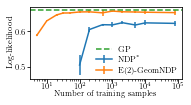

In [121]:
ci = 0.95
alpha = (1 - ci) / 2

def half_ci(group):
    data = group.to_numpy()
    sem = stats.sem(data)
    t2 = stats.t.ppf(1 - alpha, len(data) - 1) - stats.t.ppf(alpha, len(data) - 1)
    return sem * (t2 / 2)
    # return np.std(data)


metric = "cond_logp"
# metric = "prior_logp"
val_metric = metric
runs_df = runs_df.query("`data/n_train` > 1")
results = runs_df.query("`dataset` == 'Div-free' & `kernel` == 'White'")

results = (
        results.groupby(by=["method", "kernel", "dataset", "data/n_train"])
        .agg(
            {
                metric: ["mean", "std", "sem", half_ci, "count"],
                val_metric: ["mean", "std", "sem", half_ci, "count"],
                "true_" + metric: ["mean", "std", "sem", half_ci, "count"],
            }
        )
        .reset_index()
    )

dict_names = {
    "NDP (White)": r"NDP\textsuperscript{*}",
    # "SE(2)-Transformer": "SteerNDP (w/ attn)",
    "Tensor Field": "E(2)-GeomNDP",
}
results["method"] = results["method"].replace(dict_names)


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(0.45 * pw, 0.45 * pw/1.9))
# fig.subplots_adjust(wspace=0, hspace=0.0)
for i, method in enumerate(["NDP (White)", "Tensor Field"]):
    idx_method = results["method"] == dict_names[method]
    x = results[idx_method]["data/n_train"]
    y = results[idx_method][metric]["mean"]
    idx = y > -10
    # y_err = results[idx][metric]["sem"]
    y_err = results[idx_method][metric]["half_ci"]
    # print(y_err)
    ax.errorbar(x[idx], y[idx], y_err[idx], color=f"C{i}", label=dict_names[method])

# y = results[idx_method]["true_" + metric]["mean"]
# print(y)
ax.axhline(y=0.66, color='C2', linestyle='--', label="GP")

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylabel('Log-likelihood', labelpad=0.5)
ax.set_xlabel('Number of training samples', labelpad=0.8)
# ax.set_ylim(0.5, .8)
# ax.set_ylim(-100, .8)
ax.tick_params(pad=0.8)
ax.legend(frameon=False, loc='lower right', borderpad=0., labelspacing=0.4, fontsize=8)
fig.show()

# plt.tight_layout()
# fig.tight_layout(w_pad=0.2)
# fig.subplots_adjust(bottom=0, top=1, left=0.003, right=1-0.003)
fig.tight_layout(pad=0, w_pad=0.1, rect=(0.01,0.01,0.99,0.98))
# fig.savefig(os.path.join(dir_path, '2d/steerable_demo.pdf'), bbox_inches=mpl.transforms.Bbox([[0,0.14],[lw, lw/2.5 + 0.07]]))
fig.savefig(os.path.join(dir_path, '2d/ablation_training_samples.pdf'))

# results



In [49]:
# Manually adding the CNP results!

columns = ['group', 'method', "config/seed", 'dataset', 'cond_logp']
rows = [
    ["ConvCNP", "ConvCNP", 1, "Curl-free", -1.7677894592285157],
    ["ConvCNP", "ConvCNP", 2, "Curl-free", -1.7930784861246745],
    ["ConvCNP", "ConvCNP", 3, "Curl-free", -1.7732168833414714],
    ["ConvCNP", "ConvCNP", 4, "Curl-free", -1.7641785939534504],
    ["ConvCNP", "ConvCNP", 5, "Curl-free", -1.7661763509114583],
    ["ConvCNP", "ConvCNP", 1, "Div-free", -1.7574120839436849],
    ["ConvCNP", "ConvCNP", 2, "Div-free", -1.7526724497477213],
    ["ConvCNP", "ConvCNP", 3, "Div-free", -1.7614798227945963],
    ["ConvCNP", "ConvCNP", 4, "Div-free", -1.7596895853678385],
    ["ConvCNP", "ConvCNP", 5, "Div-free", -1.7613946278889974],
    ["ConvCNP", "ConvCNP", 1, "SE", -1.7010875701904298],
    ["ConvCNP", "ConvCNP", 2, "SE", -1.7113407135009766],
    ["ConvCNP", "ConvCNP", 3, "SE", -1.7199483235677084],
    ["ConvCNP", "ConvCNP", 4, "SE", -1.7112767537434896],
    ["ConvCNP", "ConvCNP", 5, "SE", -1.6989725748697917],
    ["C4", "SteerCNP", 1, "Curl-free", -1.5672126770019532],
    ["C4", "SteerCNP", 2, "Curl-free", -1.5728504180908203],
    ["C4", "SteerCNP", 3, "Curl-free", -1.5713305155436197],
    ["C4", "SteerCNP", 4, "Curl-free", -1.5724315643310547],
    ["C4", "SteerCNP", 5, "Curl-free", -1.5712619781494142],
    ["C4", "SteerCNP", 1, "Div-free", -1.5733726501464844],
    ["C4", "SteerCNP", 2, "Div-free", -1.5614351908365884],
    ["C4", "SteerCNP", 3, "Div-free", -1.574195353190104],
    ["C4", "SteerCNP", 4, "Div-free", -1.5771334330240885],
    ["C4", "SteerCNP", 1, "SE", -1.6106020609537761],
    ["C4", "SteerCNP", 2, "SE", -1.6136614481608074],
    ["C4", "SteerCNP", 3, "SE", -1.6125297546386719],
    ["C4", "SteerCNP", 4, "SE", -1.6106975555419922],
    ["C4", "SteerCNP", 5, "SE", -1.6165941874186198],
    ["GP", "GP", 1, "Curl-free", 0.6598717212677002],
    ["GP", "GP", 2, "Curl-free", 0.6598289966583252],
    ["GP", "GP", 3, "Curl-free", 0.6598330497741699],
    ["GP", "GP", 4, "Curl-free", 0.6598613739013672],
    ["GP", "GP", 5, "Curl-free", 0.6598188877105713],
    ["GP", "GP", 1, "Div-free", 0.6602359294891358],
    ["GP", "GP", 2, "Div-free", 0.6602742195129394],
    ["GP", "GP", 3, "Div-free", 0.6602205753326416],
    ["GP", "GP", 4, "Div-free", 0.6602634906768798],
    ["GP", "GP", 5, "Div-free", 0.6602737426757812],
    ["GP", "GP", 1, "SE", 0.5573758125305176],
    ["GP", "GP", 2, "SE", 0.5573612689971924],
    ["GP", "GP", 3, "SE", 0.5573762893676758],
    ["GP", "GP", 4, "SE", 0.5574379444122315],
    ["GP", "GP", 5, "SE", 0.5574140071868896],
    ["GP", "GP (diag.)", 1, "Curl-free", -1.4716421127319337],
    ["GP", "GP (diag.)", 2, "Curl-free", -1.4714653968811036],
    ["GP", "GP (diag.)", 3, "Curl-free", -1.4716914176940918],
    ["GP", "GP (diag.)", 4, "Curl-free", -1.471421241760254],
    ["GP", "GP (diag.)", 5, "Curl-free", -1.471923542022705],
    ["GP", "GP (diag.)", 1, "Div-free", -1.466759204864502],
    ["GP", "GP (diag.)", 2, "Div-free", -1.4690001487731934],
    ["GP", "GP (diag.)", 3, "Div-free", -1.4697052001953126],
    ["GP", "GP (diag.)", 4, "Div-free", -1.4679842948913575],
    ["GP", "GP (diag.)", 5, "Div-free", -1.4686187744140624],
    ["GP", "GP (diag.)", 1, "SE", -1.559639072418213],
    ["GP", "GP (diag.)", 2, "SE", -1.5616438865661622],
    ["GP", "GP (diag.)", 3, "SE", -1.5610824584960938],
    ["GP", "GP (diag.)", 4, "SE", -1.5596550941467284],
    ["GP", "GP (diag.)", 5, "SE", -1.5608834266662597],
    ]
cnp_runs_df = pd.DataFrame(rows, columns=columns)
runs_df = pd.concat([runs_df, cnp_runs_df])

In [50]:
def format(table, row_names=[]):
    cols = ["method", "dataset", "result"]
    table = table[cols].pivot(index="method", columns="dataset")
    if len(row_names) > 0:
        table = table.reindex(row_names)
    table.index = [f"\\scshape {x}" for x in table.index]

    table = table.droplevel(level=0, axis=1)
    table = table.droplevel(level=0, axis=1)
    table = table[["SE", "Curl-free", "Div-free"]]
    table.columns = [f"\\scshape {x}" for x in table.columns]
    table.columns.name = "\\textsc{Model}"
    table.index.name = None
    return table

metric = "cond_logp"
# metric = "prior_logp"
# metric = "true_logp"

non_gp_idx = runs_df["method"].isin(["GP", "GP (diag.)"])

test_table = make_table_from_metric(
    metric, runs_df[~non_gp_idx], val_metric=metric, drop_nans=False, latex=True, bold=True, show_group=False, select_best=True
)
dict_names = {
    "NDP (White)": "\\method",
    "SteerCNP": "E(2)-SteerCNP",
    # "SE(2)-Transformer": "SteerNDP (w/ attn)",
    "Tensor Field": "E(2)-\\method",
}
test_table["method"] = test_table["method"].replace(dict_names)

print(test_table[["group", "result"]])
table = format(test_table, row_names=["ConvCNP", dict_names["SteerCNP"], dict_names["NDP (White)"], dict_names["Tensor Field"]])
print(table)
gp_test_table = make_table_from_metric(
    metric, runs_df[non_gp_idx], val_metric=metric, drop_nans=False, latex=True, bold=False, show_group=False, select_best=True, pm=True
)
# # print(gp_test_table)
gp_table = format(gp_test_table, row_names=["GP (diag.)", "GP"])
table = pd.concat([table, gp_table])
row_names = ["GP", dict_names["NDP (White)"], dict_names["Tensor Field"], "GP (diag.)", "ConvCNP", dict_names["SteerCNP"]]
table = table.reindex([f"\\scshape {row}" for row in row_names])

import os
latex_path = "table.tex"
filename = os.path.join(os.getcwd(), latex_path)
print(filename)
table.style.to_latex(
    buf=filename, hrules=True, multicol_align="c", column_format="lccc"
)
table

                                                                                                               group  \
                                                                                                                       
0                                                                                                                 C4   
1                                                                                                                 C4   
2                                                                                                                 C4   
3                                                                                                            ConvCNP   
4                                                                                                            ConvCNP   
5                                                                                                            ConvCNP   
6                context_data.n_points=[

\textsc{Model},\scshape SE,\scshape Curl-free,\scshape Div-free
\scshape GP,${0.56_{\pm 0.00}}$,${0.66_{\pm 0.00}}$,${0.66_{\pm 0.00}}$
\scshape \method,${0.55_{\pm 0.00}}$,${0.62_{\pm 0.01}}$,${0.62_{\pm 0.01}}$
\scshape E(2)-\method,$\bm{0.56_{\pm 0.01}}$,$\bm{0.65_{\pm 0.01}}$,$\bm{0.66_{\pm 0.01}}$
\scshape GP (diag.),${-1.56_{\pm 0.00}}$,${-1.47_{\pm 0.00}}$,${-1.47_{\pm 0.00}}$
\scshape ConvCNP,${-1.71_{\pm 0.01}}$,${-1.77_{\pm 0.01}}$,${-1.76_{\pm 0.00}}$
\scshape E(2)-SteerCNP,${-1.61_{\pm 0.00}}$,${-1.57_{\pm 0.00}}$,${-1.57_{\pm 0.01}}$


In [9]:
table = make_table_from_metric(
    "cond_logp", runs_df, val_metric="cond_logp", drop_nans=False, latex=True, bold=True, show_group=False, select_best=False
)
# with pd.option_context('display.max_colwidth', None):
pd.options.display.max_colwidth=None
table#[["group", "result"]]


group  \
                                                                                                        
0                                                                                                  C4   
1                                                                                                  C4   
2                                                                                                  C4   
3                                                                                             ConvCNP   
4                                                                                             ConvCNP   
..                                                                                                ...   
56  context_data.n_points=[25,648],data.n_train=80000,data_kernel=rbfvec,net.attention=False,net=e3nn   
57   context_data.n_points=[25,648],data.n_train=80000,data_kernel=rbfvec,net.attention=True,net=e3nn   
58                     context_data.n_points=[25,648],data.n_train=80000,data_kernel=rbfvec,net=mattn   
59                    context_data.n_points=[25,648],net.attention=false,net=e3nn,optim.batch_size=30   
60                                             debug_data.n_points=[25,648],data.n_train=32,net=mattn   

               method    dataset     cond_logp                                \
                                          mean       std       sem  lower_ci   
0            SteerCNP  Curl-free     -1.571017  0.002236  0.001000 -1.573793   
1            SteerCNP   Div-free     -1.571534  0.006923  0.003462 -1.582551   
2            SteerCNP         SE     -1.612817  0.002473  0.001106 -1.615888   
3             ConvCNP  Curl-free     -1.772888  0.011776  0.005266 -1.787509   
4             ConvCNP   Div-free     -1.758530  0.003668  0.001640 -1.763084   
..                ...        ...           ...       ...       ...       ...   
56       Tensor Field         SE      0.561652  0.004158  0.001859  0.556490   
57  SE(2)-Transformer         SE      0.555098  0.003398  0.001520  0.550879   
58        NDP (White)         SE      0.547703  0.000773  0.000346  0.546743   
59       Tensor Field   Div-free      0.640560       NaN       NaN       NaN   
60        NDP (White)   Div-free -10082.861152       NaN       NaN       NaN   

                             group_max   bold                   result count  
    upper_ci   half_ci count                                                  
0  -1.568241  0.002776     5         6  False     ${-1.57_{\pm 0.00}}$     5  
1  -1.560517  0.011017     4         7  False     ${-1.57_{\pm 0.01}}$     4  
2  -1.609747  0.003070     5        56  False     ${-1.61_{\pm 0.00}}$     5  
3  -1.758267  0.014621     5         6  False     ${-1.77_{\pm 0.01}}$     5  
4  -1.753975  0.004554     5         7  False     ${-1.76_{\pm 0.00}}$     5  
..       ...       ...   ...       ...    ...                      ...   ...  
56  0.566814  0.005162     5        56   True   $\bm{0.56_{\pm 0.01}}$     5  
57  0.559318  0.004220     5        56  False      ${0.56_{\pm 0.00}}$     5  
58  0.548663  0.000960     5        56  False      ${0.55_{\pm 0.00}}$     5  
59       NaN       NaN     1         7  False       ${0.64_{\pm nan}}$     1  
60       NaN       NaN     1         7  False  ${-10082.86_{\pm nan}}$     1  

[61 rows x 14 columns]